# Credit Risk Model

** By Carolyn Koay **  |  ** Last edited on 6 February 2018 **

The data source is from <https://www.kaggle.com/c/GiveMeSomeCredit>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from copy import deepcopy

## Read and Explore Data

In [2]:
df = pd.read_csv('cs-training.csv')

print(df.head(4))


   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3          

The first column, which is unnamed, is simply a running series of integers starting from 1. 
Let's rename this column to 'ID'. 

In [3]:
df.columns = ['ID'] + list(df)[1:]
names = list(df)
summary = df.describe(include = 'all')
print(summary)

                  ID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                            

The summary of the target variable, 'SeriousDlqin2yrs' shows that the target variable takes only 2 values: 0 for no default and 1 for default. Based on a mean of 0.06684, we can tell that the proportion of defaults in the data set is 6.7%. 
Let's set this as priors. 

In [4]:
# Get priors
priors = [1-summary.loc['mean','SeriousDlqin2yrs'], summary.loc['mean','SeriousDlqin2yrs']]

## Clean Data

Any variables with count not equal to 150000, have missing values. 
There are 2 such variables: 'MonthlyIncome' and 'NumberOfDependents'. 
Since the missing values did not exceed 25% of the data, let's replace the missing values with the median of the variables.  

In [5]:
# Replace NA with median values
fill_values = {}
for i in range(2, df.shape[1]):
    fill_values[df.columns[i]] = np.nanmedian(df[df.columns[i]])
df2 = df.fillna(fill_values)

By observing the quantiles and the max values, we can tell that the data is positively skewed with many positive outliers. 
Let's replace the outliers with the upper/lower limit of our tolerance. 
In this case, our tolerance is set to +/-4 standard deviations away from the mean. 

In [6]:
# Handle outliers
def find_outliers(dt, tol):
    outliers = []
    summ = dt.describe()
    for i in dt: 
        if abs(i-summ['mean'])/summ['std'] > tol : 
            outliers.append(True)
        else:
            outliers.append(False)
    
    return outliers

def replace_outliers(dt, tol):
    new = []
    summ = dt.describe()
    for i in dt: 
        if (i-summ['mean'])/summ['std'] > tol : 
            new.append(round(summ['mean'] + tol*summ['std'], 0))
        elif (i-summ['mean'])/summ['std'] < -tol : 
            new.append(round(summ['mean'] - tol*summ['std'],0))
        else:
            new.append(i)
    return pd.Series(new, name = dt.name)
            
for i in names[2:]: 
    if sum(find_outliers(df2[i], tol = 4)) < 0.01 * df2.shape[0] :
        df2.loc[:,i] = replace_outliers(df2[i], tol = 4).values

summary2 = df2.describe(include = 'all')
print(summary2)


                  ID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              1.684505   
std     43301.414527          0.249746                             36.114760   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                           1005.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.275840     332.441926   
std        14.771866                            

## Partition Data

The data is partitioned to training and test sets with a proportion of 0.8:0.2. 

In [7]:
def partition_data(data, x_col, y_col, train_test_prop):
    np.random.seed(2018)
    names = list(data)
    train = np.random.choice([True, False], size =data.shape[0], p = train_test_prop )
    x_train = data[train][[names[i]for i in x_col]].as_matrix()
    y_train = data[train][names[y_col]].as_matrix()
    x_test = data[~train][[names[i]for i in x_col]].as_matrix()
    y_test = data[~train][names[y_col]].as_matrix()
    return train, x_train, y_train, x_test, y_test

train, x_train, y_train, x_test, y_test = partition_data(df2, x_col = range(2, df2.shape[1]), y_col=1, train_test_prop = [0.8, 0.2])


## Scale Data

Scale the predictor data to range between 0 and 1. 
This is because the 'MonthlyIncome' variable clearly has a different scale from the other variables which are count data. 

In [8]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Build Baseline Models

This project looks at 4 types of base classifiers: Logistic Regression, Support Vector Machines, Decision Trees and Gaussian Naive Bayes. 
We will first establish baseline models with optimal parameters using Grid Search. 
The parameters are mainly related to regularization to prevent overfitting. 

*Note: Gaussian Naive Bayes models do not have any parameters to optimize.

The scoring metric will be 'roc_auc' or Area Under the Receiver Operating Curve. Higher values are better. Scoring of cross-validation data is used by Grid Search to select the best model. However, only scoring of test data will matter in comparison to subsequent experiments. 

In [9]:
from sklearn import metrics
from sklearn import linear_model, tree, svm, naive_bayes
from sklearn import model_selection, calibration

clf_baseline = {}
clf_baseline_val_scores = {}
clf_baseline_test_scores = {}

logit = linear_model.LogisticRegression()
params = {'C': [1, 0.1, 0.01, 0.001]}
gs_logit = model_selection.GridSearchCV(logit, params, scoring = 'roc_auc')
gs_logit.fit(x_train, y_train)
clf_baseline['logit'] = gs_logit.best_estimator_
clf_baseline_val_scores['logit'] = gs_logit.best_score_
y_pred = gs_logit.best_estimator_.predict(x_test)
clf_baseline_test_scores['logit'] = metrics.roc_auc_score(y_test, y_pred)
print('Best params for Logit: \n', gs_logit.best_params_)

svc = svm.LinearSVC()
params = {'C': [1, 0.1, 0.01, 0.001]}
gs_svc = model_selection.GridSearchCV(svc, params, scoring = 'roc_auc')
gs_svc.fit(x_train, y_train)
clf_baseline['svc'] = gs_svc.best_estimator_
clf_baseline_val_scores['svc'] = gs_svc.best_score_
y_pred = gs_svc.best_estimator_.predict(x_test)
clf_baseline_test_scores['svc'] = metrics.roc_auc_score(y_test, y_pred)
print('Best params for SVC: \n', gs_svc.best_params_)

dt = tree.DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [0.2, 0.1, 0.01, 0.001, 0.0001]}
gs_dt = model_selection.GridSearchCV(dt, params, scoring = 'roc_auc')
gs_dt.fit(x_train, y_train)
clf_baseline['dt'] = gs_dt.best_estimator_
clf_baseline_val_scores['dt'] = gs_dt.best_score_
y_pred = gs_dt.best_estimator_.predict(x_test)
clf_baseline_test_scores['dt'] = metrics.roc_auc_score(y_test, y_pred)
print('Best params for DT: \n', gs_dt.best_params_)

gnb = naive_bayes.GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
clf_baseline ['gnb'] = gnb
clf_baseline_test_scores['gnb'] = metrics.roc_auc_score(y_test, y_pred)

Best params for Logit: 
 {'C': 1}
Best params for SVC: 
 {'C': 0.01}
Best params for DT: 
 {'criterion': 'gini', 'min_samples_leaf': 0.01}


In [10]:
print('AUC score on test data for each baseline classifiers:\n')
for k,v in clf_baseline_test_scores.items():
    print(k, ':',v)

AUC score on test data for each baseline classifiers:

logit : 0.53024537827
svc : 0.507953246205
dt : 0.574616673409
gnb : 0.606284717947


## Experiment to Find Best Strategy for Data with Unbalanced Target Distribution

The experiment employs 3 main strategies to tackle data with unbalanced target distribution. 
1. Undersample the majority data (i.e. target = 0)
2. Adjust the class weights during model fitting to put more penalization of the cost function on the minority data (i.e. target = 1) 
3. Change the decision threshold to label a prediction as 1 or 0 based on its predicted probability. The default value is 0.5. 

Below are the 3 functions to implement the strategies. 

In [11]:
## Function to undersample data
def undersample(x_train, y_train, true_false_prop):   
    np.random.seed(2018)
    y_true = y_train[y_train == 1]
    y_false = y_train[y_train == 0]
    x_true = x_train[y_train == 1]
    x_false = x_train[y_train == 0]
    
    sampling_pct = true_false_prop[1]/true_false_prop[0]*y_true.shape[0]/y_false.shape[0]
    sample = np.random.choice([True, False], size = y_false.shape[0], p = [sampling_pct, 1-sampling_pct])
    
    y_false2 = y_false[sample]
    x_false2 = x_false[sample]
    
    x = np.concatenate([x_true, x_false2])
    y = np.concatenate([y_true, y_false2])
    data = np.column_stack((x,y))
    np.random.shuffle(data)
    
    x_train2 = data[:,:-1]
    y_train2 = data[:,-1]
    return x_train2, y_train2

## Function to set class_weights
def add_class_weights (clf, priors):
    # weights must be a dictionary with the keys representing each class. 
    # if clf is a GaussianNB classifier, the keys must be sorted.    
    
    if str(type(clf)) == "<class 'sklearn.naive_bayes.GaussianNB'>": 
        clf.set_params(priors = priors)
    else: 
        if priors == None: 
            clf.set_params(class_weight = None)
        else: 
            weights = {}
            for i in range(2):
                weights[i] = round(1/priors[i])
            clf.set_params(class_weight = weights)

    return clf

## Function to find best decision threshold
def find_best_threshold(clf, x_test, y_test, score): 
    
    scoring = {'Accuracy': metrics.accuracy_score,
               'Precision': metrics.precision_score,
               'Recall': metrics.recall_score,
               'F1': metrics.f1_score,
               'AUC': metrics.roc_auc_score}    
    
    y_proba = clf.predict_proba(x_test)
    
    scores = {}
    preds = {}
    for i in np.arange(0.1,1,0.1):
        y_pred = np.zeros(shape = (y_proba.shape[0],1))
        for j in range(0, y_proba.shape[0]):
            if y_proba[j,1]>i:
                y_pred[j] = 1
            else:
                y_pred[j] = 0
                
        scores[i] = scoring[score](y_test,y_pred)
        preds[i] = y_pred
    
    best_threshold = max(scores, key=scores.get)
    best_score = max(scores.values())
    best_pred = preds[best_threshold]
    
    return best_threshold, best_score, best_pred

The experiments are designed to employ all possible combination of the 3 strategies (7) on all 4 base models established earlier. There will be 28 experiments in total. 

In [12]:
## Setup experiment 
x_train2, y_train2 = undersample(x_train, y_train, [1,1])

doe = [[1,0,0],
       [0,1,0],
       [0,0,1],
       [1,1,0],
       [1,0,1],
       [0,1,1],
       [1,1,1]]
clf = pd.DataFrame(doe, columns = ['Undersample', 'Weights', 'Threshold'])
clf = clf.append(clf.append(clf.append(clf)))
clf.reset_index(inplace = True, drop = True)
clf_types = ['logit', 'svc', 'dt','gnb']
classifier = []
for i in range(4):
    count = 0
    while count < 7:
        classifier.append(clf_types[i])
        count+=1
clf['Classifier'] = classifier
clf['ID'] = [str(clf['Undersample'][i])+str(clf['Weights'][i])+str(clf['Threshold'][i])+str(clf['Classifier'][i]) for i in range(clf.shape[0])]


In [13]:
## Run experiment
models = {}
scores = {}
y_preds = {}
for i in range(clf.shape[0]):    
    
    model = clf_baseline[clf['Classifier'][i]]
          
    if clf['Weights'][i] == 1:
        model = add_class_weights(model,priors)
    else: 
        model = add_class_weights(model,None)
    
    if clf['Undersample'][i] == 1:
        x_tr = x_train2
        y_tr = y_train2
    else:
        x_tr = x_train
        y_tr = y_train
           
    model.fit(x_tr, y_tr)
    models[clf['ID'][i]] = deepcopy(model)
        
    if clf['Threshold'][i] == 1:
        if str(type(model)) == "<class 'sklearn.svm.classes.LinearSVC'>": 
            model = calibration.CalibratedClassifierCV(model, cv = 'prefit')
            model.fit(x_tr, y_tr)    
        threshold, auc, y_pred = find_best_threshold(model, x_test, y_test, 'AUC')   
    else: 
        threshold = 0.5
        y_pred = model.predict(x_test)
        auc = metrics.roc_auc_score(y_test, y_pred)
        
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    scores[clf['ID'][i]] = [threshold, accuracy, precision, recall, f1, auc]
    y_preds[clf['ID'][i]] = y_pred

scores = pd.DataFrame([[key]+value for key,value in scores.items()], columns = ['ID','Threshold','Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])    


Let's look at the scores.

In [14]:
print(scores)

          ID  Threshold  Accuracy  Precision    Recall        F1       AUC
0   100logit        0.5  0.822416   0.218572  0.618093  0.322943  0.727769
1   010logit        0.5  0.827810   0.227833  0.633252  0.335102  0.737687
2   001logit        0.1  0.886916   0.292058  0.456724  0.356285  0.687642
3   110logit        0.5  0.069191   0.068567  1.000000  0.128334  0.500360
4   101logit        0.5  0.822416   0.218572  0.618093  0.322943  0.727769
5   011logit        0.5  0.827810   0.227833  0.633252  0.335102  0.737687
6   111logit        0.9  0.645870   0.137400  0.789731  0.234075  0.712509
7     100svc        0.5  0.736271   0.155185  0.641076  0.249881  0.692175
8     010svc        0.5  0.753225   0.165661  0.644499  0.263574  0.702861
9     001svc        0.1  0.892980   0.305978  0.443032  0.361966  0.684555
10    110svc        0.5  0.068521   0.068521  1.000000  0.128253  0.500000
11    101svc        0.6  0.833976   0.213018  0.528117  0.303584  0.692296
12    011svc        0.1  

The best performing models for each classifier type are: 

1. 010logit: 0.737687 (adjust class weights)
2. 111svc: 0.705443 (employ all 3 strategies)
3. 100dt: 0.769434 (undersample)
4. 101gnb: 0.704004 (undersample and adjust decision threshold)

All the models performed better than the baseline classifiers. 
Let's look at the confusion matrix and ROC Curve for each of the models. 

Confusion matrix legend: 

[[TN FP]

 [FN TP]]


Confusion Matrix for  010logit : 
 [[23411  4389]
 [  750  1295]]

ROC Curve for  010logit : 


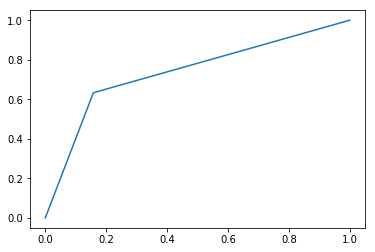


Confusion Matrix for  111svc : 
 [[20721  7079]
 [  684  1361]]

ROC Curve for  111svc : 


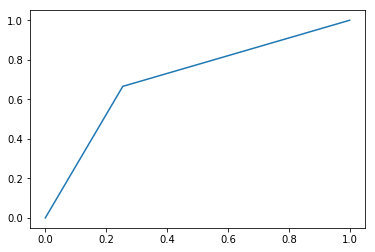


Confusion Matrix for  100dt : 
 [[22199  5601]
 [  531  1514]]

ROC Curve for  100dt : 


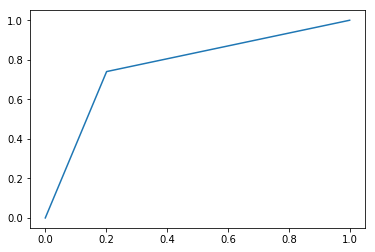


Confusion Matrix for  101gnb : 
 [[25766  2034]
 [ 1061   984]]

ROC Curve for  101gnb : 


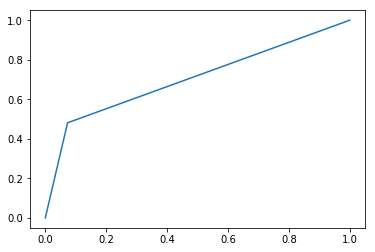

In [15]:
for i in [1,13,14,25]: 
    print('\nConfusion Matrix for ', clf['ID'][i], ': \n',metrics.confusion_matrix(y_test,y_preds[clf['ID'][i]]))
    print('\nROC Curve for ', clf['ID'][i], ': ')
    roc = metrics.roc_curve(y_test, y_preds[clf['ID'][i]])
    plt.plot(roc[0], roc[1])
    plt.show()

## Interpreting Results

In [16]:
best_logit = models[clf['ID'][1]] 
predictors = [names[i]for i in range(2, df2.shape[1])]
coef = best_logit.coef_.tolist()[0]
coefficients = {}
for i in range(len(predictors)):
    coefficients[predictors[i]] = coef[i]
coefficients['intercept'] = best_logit.intercept_[0]

coefficients = sorted(coefficients.items(), key=operator.itemgetter(1), reverse = True)
print('Coefficients of the Logistic Regression Model:\n')
for i in coefficients:
    print(i[0], ':',i[1])
print('\n')

Coefficients of the Logistic Regression Model:

NumberOfTimes90DaysLate : 17.519201925628142
NumberOfTime60-89DaysPastDueNotWorse : 12.525353809926791
NumberOfTime30-59DaysPastDueNotWorse : 11.864752640143452
intercept : 0.814570230737
NumberRealEstateLoansOrLines : 0.4667846125508872
NumberOfOpenCreditLinesAndLoans : 0.4166401325673546
NumberOfDependents : 0.2968073691781466
RevolvingUtilizationOfUnsecuredLines : 0.24146396276828586
DebtRatio : -0.4334507591257001
MonthlyIncome : -1.9508999080225464
age : -3.2134783517064656




In [17]:
best_svc = models[clf['ID'][13]] 
coef = best_svc.coef_.tolist()[0]
coefficients = {}
for i in range(len(predictors)):
    coefficients[predictors[i]] = coef[i]
coefficients['intercept'] = best_svc.intercept_[0]

coefficients = sorted(coefficients.items(), key=operator.itemgetter(1), reverse = True)
print('Coefficients of the Decision Function of the SVC Model:\n')
for i in coefficients:
    print(i[0], ':',i[1])
print('\n')

Coefficients of the Decision Function of the SVC Model:

NumberOfTimes90DaysLate : 1.2447831962420133
NumberOfTime30-59DaysPastDueNotWorse : 1.1962223881264535
intercept : 1.01244606939
NumberOfTime60-89DaysPastDueNotWorse : 0.9130887765466893
NumberOfOpenCreditLinesAndLoans : 0.0908857580138883
NumberRealEstateLoansOrLines : 0.07534089550199755
RevolvingUtilizationOfUnsecuredLines : 0.06392228822380676
NumberOfDependents : 0.05506412635964687
DebtRatio : -0.06369476341141772
MonthlyIncome : -0.2827283563800224
age : -0.5774558927085341




Feature Importances of the Decision Tree Model:

RevolvingUtilizationOfUnsecuredLines : 0.566193683618
NumberOfTime30-59DaysPastDueNotWorse : 0.18344763672
NumberOfTimes90DaysLate : 0.157824865225
age : 0.0291063244215
NumberOfTime60-89DaysPastDueNotWorse : 0.0225662590286
DebtRatio : 0.0147537610774
NumberOfOpenCreditLinesAndLoans : 0.0128703380843
NumberRealEstateLoansOrLines : 0.00850750339156
MonthlyIncome : 0.00472962843404
NumberOfDependents : 0.0


Decision Tree Diagram:
On ipynb, you may zoom in and scroll to observe. 

Legend for the variables
X 0 : RevolvingUtilizationOfUnsecuredLines
X 1 : age
X 2 : NumberOfTime30-59DaysPastDueNotWorse
X 3 : DebtRatio
X 4 : MonthlyIncome
X 5 : NumberOfOpenCreditLinesAndLoans
X 6 : NumberOfTimes90DaysLate
X 7 : NumberRealEstateLoansOrLines
X 8 : NumberOfTime60-89DaysPastDueNotWorse
X 9 : NumberOfDependents


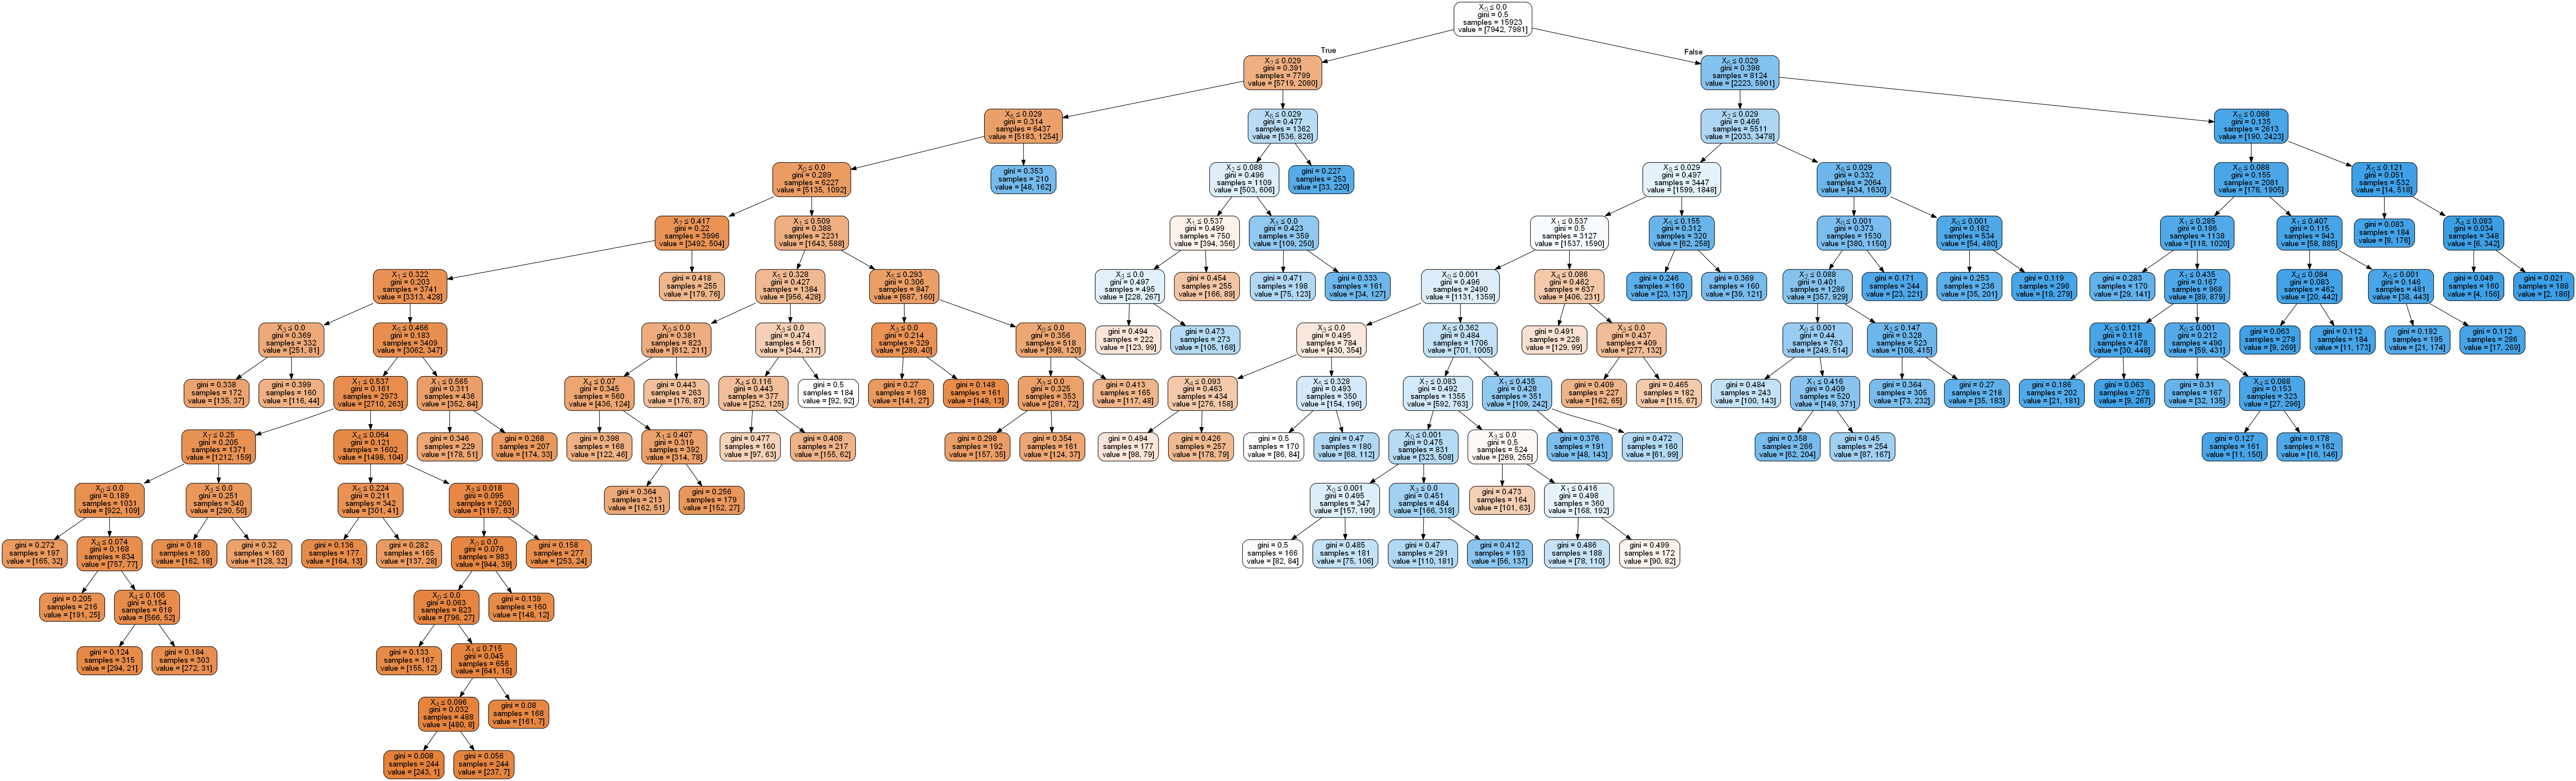

In [18]:
best_dt = models[clf['ID'][14]]

feature_imp = best_dt.feature_importances_
importance = {}
for i in range(len(predictors)):
    importance[predictors[i]] = feature_imp[i]

importance = sorted(importance.items(), key=operator.itemgetter(1), reverse = True)
print('Feature Importances of the Decision Tree Model:\n')
for i in importance:
    print(i[0], ':', i[1])
print('\n')

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(best_dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print('Decision Tree Diagram:')
print('On ipynb, you may zoom in and scroll to observe. \n')
print('Legend for the variables')
for i in range(len(predictors)):
    print('X',i, ':', predictors[i])

Image(graph.create_png())

In [19]:
best_gnb = models[clf['ID'][25]]
mean_0 = best_gnb.theta_[0]
mean_1 = best_gnb.theta_[1]
means = pd.DataFrame([mean_0, mean_1],columns = predictors).T
sd_0 = best_gnb.sigma_[0]
sd_1 = best_gnb.sigma_[1]
sd = pd.DataFrame([sd_0, sd_1],columns = predictors).T

print('Mean of the Gaussian Distributions of the Predictor Vectors for Target 0 and 1: \n')
print(means)
print('\n')
print('Standard Deviation of the Gaussian Distributions of the Predictor Vectors for Target 0 and 1:\n')
print(sd)

Mean of the Gaussian Distributions of the Predictor Vectors for Target 0 and 1: 

                                             0         1
RevolvingUtilizationOfUnsecuredLines  0.001169  0.001754
age                                   0.494791  0.429353
NumberOfTime30-59DaysPastDueNotWorse  0.011991  0.071582
DebtRatio                             0.039674  0.032911
MonthlyIncome                         0.109199  0.094613
NumberOfOpenCreditLinesAndLoans       0.289161  0.271671
NumberOfTimes90DaysLate               0.003592  0.054173
NumberRealEstateLoansOrLines          0.165366  0.158731
NumberOfTime60-89DaysPastDueNotWorse  0.002859  0.038555
NumberOfDependents                    0.142231  0.186543


Standard Deviation of the Gaussian Distributions of the Predictor Vectors for Target 0 and 1:

                                             0         1
RevolvingUtilizationOfUnsecuredLines  0.000812  0.001008
age                                   0.019125  0.014640
NumberOfTime30-59DaysPa

## Ensemble Models

Now let's try some ensemble models using decision trees as base classifier, since it has the best results out of the four types of classifiers. 


Confusion Matrix for  bag : 
 [[21864  5936]
 [  512  1533]]

ROC Curve for  bag : 


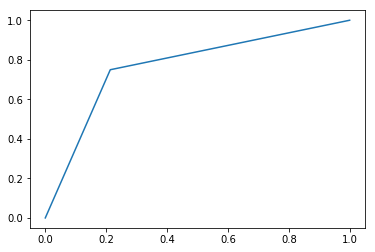


Confusion Matrix for  rf : 
 [[21434  6366]
 [  447  1598]]

ROC Curve for  rf : 


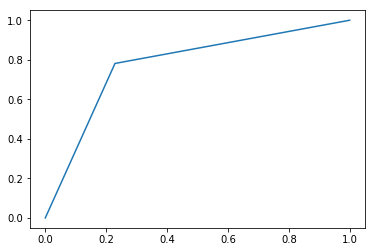


Confusion Matrix for  ada : 
 [[20823  6977]
 [  553  1492]]

ROC Curve for  ada : 


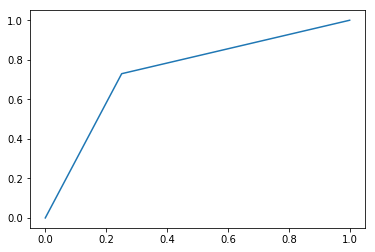

    ID  Threshold  Accuracy  Precision    Recall        F1       AUC
0  bag        0.5  0.783950   0.205248  0.749633  0.322262  0.768054
1   rf        0.5  0.771721   0.200653  0.781418  0.319313  0.776213
2  ada        0.5  0.747696   0.176172  0.729584  0.283812  0.739307


In [20]:
base = deepcopy(best_dt)

from sklearn import ensemble
bag = ensemble.BaggingClassifier(base, n_estimators = 50)
rf = ensemble.RandomForestClassifier(min_samples_leaf=0.01, n_estimators = 50) 
ada = ensemble.AdaBoostClassifier(base, n_estimators = 50)

ensemble_clf = {'bag': bag,'rf': rf, 'ada': ada}

ensemble_scores = {}

for k, v in ensemble_clf.items():
    v.fit(x_train2, y_train2)
    y_proba = v.predict_proba(x_test)
    threshold, auc, y_pred = find_best_threshold(v, x_test, y_test,'AUC')
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    
    ensemble_scores [k] = [threshold, accuracy, precision, recall, f1, auc]
    print('\nConfusion Matrix for ', k, ': \n',metrics.confusion_matrix(y_test,y_pred))
    print('\nROC Curve for ', k, ': ')
    roc = metrics.roc_curve(y_test, y_pred)
    plt.plot(roc[0], roc[1])
    plt.show()
    
    
ensemble_scores = pd.DataFrame([[key]+value for key,value in ensemble_scores.items()], columns = ['ID','Threshold','Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])    

print(ensemble_scores)